<a href="https://colab.research.google.com/github/giuliocapecchi/LM-project/blob/main/complete_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PDF Preprocessing and Documents Creations

---

Nowadays one of the challenging aspects of preprocessing scientific documents, for the implementation of a RAG (*Retrieval-Augmented Generation*) system, is the accurate **extraction of mathematical formulas**. Considering working with files containing this type of information, we faced the need to adopt a solution that would allow us to achieve results as good and reliable as possible using free tools and resources.

In addition to this, for completeness we report other main relevant tasks, regarding the processing of files in order to implement a RAG system, we tried to manage:
*   **handle complex structures** mantaning contextual meaning;
*   **text cleaning** removing irrilevant elements;
*   **chunk size balancing** accordingly with the specific context limit for the chosen LLM;
*   **text splitting** avoiding breaking meaningful connections in sentences.

For this purpose we propose an hybrid approach that combines multiple solutions. In particular we built a pipeline that integrates functionalities of two solutions:
*   `Unstructure`, an open-source tool efficient in transforming unstructured data into structured outputs.
    *   https://github.com/Unstructured-IO
*   `Nougat`, an advanced Transformer-based OCR model that simplifies the process of converting complex scientific contents into a common and machine-readable format.
    *   https://github.com/facebookresearch/nougat

The tasks we have addressed to these tools are respectively:
1.   Parse the PDF file obtaning **elements characterized by type and content** through `Unstructure partition function`. This allowed us to:
    *   clean the extracted contents **filering out irrelevant or meaningless types** of elements;
    *   identify page breaks, permetting to implement a **page content-aware solution**;
    *   **locate the formulas**, saving indexes of pages containing them;
    *   translate elements into **a dataframe, with columns Type and Value**, for easier handling.

2.   Extract formulas in more accurate and replicable Latex format thanks to `Nougat`. This was done according to the following logic:
    *   **only pages in** which we know **there is at least one formula are processed**, allowing us to save resources and time by avoiding analyzing the pages of the file in which no formulas appear;
    *   the selected pages are converted into images, analyzed using a **Transformer-based OCR model**, and returned as text formatted in LaTeX;
    *   the model's output is analyzed to identify **Latex patterns matching formulas**, which are then extracted.

This approach was necessary because, despite employing a high-resolution element identification strategy in Unstructured partitioning, the formulas often turned out incorrect and failed to meet our expectations. Therefore, we retained the use of `Unstructured` for its ability to implement an **elements and page-aware solution** while integrating `Nougat` in a specialized manner **for extracting mathematical formulas**. This combination allowed us to achieve significantly improved and optimal results.

Continuing with the numbering used above, the final processing steps are:
3.   **Replace the more precise formulas in the dataframe** where all the elements are stored. By doing this we faced the problem of mismatch between expected and extracted formulas for a single page:
    *   if no formulas extracted by `Nougat` we keep the formulas as extracted by `Unstructure`;
    *   else, if the number of extracted formulas differs from the expected one, we give priority to the formulas extracted by `Nougat`, due to more precision and accuracy, discarding the ones extracted by `Unstructure`.
4.   **Page-based Chunks creation**. This was done according to the following logic:
    *   setting a **threshold as the maximum number of tokens** that can be included into a single chunk;
    *   creating chunks by **concatenating page-by-page content** to preserve contextual integrity as much as possible;
    *   if the content of a single page exceeds the threshold, we concatenate **elements one by one until the content remains under the limit**. This approach is a tradeoff between the balancing of chunk sizes and the coherence of contextual structures.

Let's dive into the implementation.


Installing required libraries.

In [1]:
#%pip install -q torch gdown huggingface_hub python-dotenv transformers sentence-transformers pymupdf python-Levenshtein nltk chromadb tqdm unidecode gradio bitsandbytes seaborn unstructured[pdf] langchain langchain-community langchain-huggingface latex2mathml --progress-bar off

### Installing Additional Required Libraries

On Colab, the installations above are sufficient. However, on **Windows** and **macOS**, additional steps are required to install libraries necessary for **Unstructured** and **Nougat**:

- **Poppler**: a PDF rendering library.  
- **Tesseract**: an open-source OCR engine.

---

#### **Steps for Windows**
The easiest way to install the required libraries on Windows is via Conda (assuming Conda is installed):

1. **Install the required packages**:
    ```bash
    %conda install -c conda-forge poppler tesseract -y
    %pip install -q python-magic-bin==0.4.14
    ```

2. **Add Tesseract to the system PATH**:
    Use the following Python code to set up the `TESSDATA_PREFIX` environment variable:

    ```python
    import os, sys

    # Get the path of the current Conda environment
    conda_env_path = os.path.dirname(sys.executable)
    tessdata_path = os.path.join(conda_env_path, "share", "tessdata") # the necessary files should be here

    # Set the TESSDATA_PREFIX environment variable
    os.environ["TESSDATA_PREFIX"] = os.path.join(conda_env_path, "share")
    print("TESSDATA_PREFIX:", os.environ["TESSDATA_PREFIX"])

    # Verify the tessdata directory
    if os.path.exists(tessdata_path):
        print(f"Tessdata directory found: {tessdata_path}")
    else:
        print(f"Tessdata directory not found: {tessdata_path}")
    ```

#### **Steps for macOS**
On macOS, installation is simpler. Use the following command to install the required libraries:

1. **Install the required packages**:
    ```bash
    brew install poppler tesseract
    ```

2. **Verify the installation**:
    Check if Tesseract is properly installed by running:
    ```bash
    tesseract --version
    ```

---

Still, this approach serves as an enhancement to the RAG pipeline, enabling more accurate extraction from PDFs, particularly for elements like mathematical formulas in scientific papers. However, it is not mandatory; if the PDF contains mostly plain text, a simpler chunking method may be sufficient and more straightforward.

In [2]:
import nltk

print(nltk.__version__)  # must be 3.9.1

nltk.download("punkt")

3.9.1


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\giuli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Let's download the selected PDF for this analysis. You can choose any PDF you prefer, but keep in mind that your evaluation phase will have to differ.

> **Note:** To speed up execution, we’ll also download the `elements.pkl` file to bypass some computationally expensive processing (which would otherwise take approximately *20/30 minutes* for ~300 pages).

In [3]:
import os
import gdown


PDF_NAME = "Information Retrieval Slides.pdf"
if os.path.exists(PDF_NAME):
    print(f"File {PDF_NAME} already exists.")
else:
    # save locally from https://drive.google.com/file/d/1xUA6_ZBJzWGF7kWpM1YZTK3R1siYg1qY/view?usp=drive_link
    gdown.download(id="1xUA6_ZBJzWGF7kWpM1YZTK3R1siYg1qY", output=PDF_NAME, quiet=False)

    # download of pickled elements to speed up the execution
    gdown.download(id="17eXYgmiTL9-f9F5vIT5j7QffHIu_QwuN", output="elements.pkl", quiet=False)

File Information Retrieval Slides.pdf already exists.


## PDF Partitioning with Unstructured
Processes the PDF using the `partition` function to extract structured elements.

We decide to apply the **high-resolution strategy** because is highly sensitive, it is recommended if you want obtain precise classifications for document elements. Adopting this strategy we are able to use the document layout to gain additional information about document elements, in particular we are able to recognize:
- **Titles** and **Text** (we use them as it is)
- **Formulas** (we further process them)
- **Images** (will be removed)
- **Page Breaks** (fundamental to handle formulas and create chuncks)


In [4]:
from unstructured.partition.auto import partition
from tqdm import tqdm
import fitz  # PyMuPDF
import pickle

file_name = "Information Retrieval Slides.pdf"
title = "Information Retrieval"

load_elements_from_pickle = True
elements = []

if load_elements_from_pickle:
    # Loading the pickled elements.
    with open('elements.pkl', 'rb') as f:
        elements = pickle.load(f)
else: # Process the PDF file
    doc = fitz.open(file_name)  # open the PDF file
    total_pages = len(doc)

    for page_number in tqdm(range(total_pages), desc="Processing PDF pages"):
        # Crea un nuovo documento con una sola pagina
        temp_doc = fitz.open()  # Documento vuoto
        temp_doc.insert_pdf(doc, from_page=page_number, to_page=page_number)

        # Salva la singola pagina in un file temporaneo
        temp_page_file = f"temp_page_{page_number}.pdf"
        temp_doc.save(temp_page_file)
        temp_doc.close()

        # Applica `partition` sulla singola pagina
        page_elements = partition(
            filename=temp_page_file,
            strategy="hi_res",
            skip_infer_table_types=[],
            include_page_breaks=True,
        )
        elements.extend(page_elements)  # Aggiungi gli elementi alla lista totale
        # delete the temporary file
        os.remove(temp_page_file)

    doc.close()  # Chiudi il documento principale

# Stampa il numero totale di elementi
print("Number of recognized elements: " + str(len(elements)) + " in file " + file_name)

Number of recognized elements: 4486 in file Information Retrieval Slides.pdf


Storing the elements in a pickle file.
Snippet of code executed if needed.

In [5]:
# to uncomment, now is commented cause we are downloading the pickled elements
with open('elements.pkl', 'wb') as f:
    pickle.dump(elements, f)

## Filtering and Analyzing Extracted Elements

Here we build a **dataframe**, creating pairs of **Type** and **Value**, using the elements extracted from the PDF file.

Then we print all the different element's Type recognized.



In [6]:
import pandas as pd

df_elements = pd.DataFrame( [[type(elem), elem.text] for elem in elements], columns=['Type', 'Value'])

# Print all the unique types of elements
print(df_elements['Type'].unique())

[<class 'unstructured.documents.elements.Title'>
 <class 'unstructured.documents.elements.EmailAddress'>
 <class 'unstructured.documents.elements.PageBreak'>
 <class 'unstructured.documents.elements.ListItem'>
 <class 'unstructured.documents.elements.NarrativeText'>
 <class 'unstructured.documents.elements.Image'>
 <class 'unstructured.documents.elements.FigureCaption'>
 <class 'unstructured.documents.elements.Table'>
 <class 'unstructured.documents.elements.Text'>
 <class 'unstructured.documents.elements.Footer'>
 <class 'unstructured.documents.elements.Formula'>
 <class 'unstructured.documents.elements.Header'>]


Now we clean the dataframe filtering out all the useless elements:
- **Images** (for them we have a text extracted with OCR technique, but not very useful for the language model due to a loss of meaning)
- **Email Addresses**
- **Table** (similarly to the images they lost some meaning as they are extracted)
- **Footers** and **Headers**


In [7]:
from unstructured.documents.elements import Image, Table, Footer, Header, PageBreak

# print df number of rows
print("Number of actual elements: " + str(len(df_elements)))

# drop all the rows with unuseful Types
df_elements = df_elements[df_elements['Type'] != Image]
df_elements = df_elements[df_elements['Type'] != Table]
df_elements = df_elements[df_elements['Type'] != Footer]
df_elements = df_elements[df_elements['Type'] != Header]
df_elements = df_elements.drop(df_elements[(df_elements['Type'] != PageBreak) & (df_elements['Value'] == '')].index)

# print df number of rows
print("Number of elements after filtering: " + str(len(df_elements)))

# reassign the dataframe index
df_elements = df_elements.reset_index(drop=True)

# print all the different possible Type in the dataframe
print(df_elements['Type'].unique())


Number of actual elements: 4486
Number of elements after filtering: 4031
[<class 'unstructured.documents.elements.Title'>
 <class 'unstructured.documents.elements.EmailAddress'>
 <class 'unstructured.documents.elements.PageBreak'>
 <class 'unstructured.documents.elements.ListItem'>
 <class 'unstructured.documents.elements.NarrativeText'>
 <class 'unstructured.documents.elements.FigureCaption'>
 <class 'unstructured.documents.elements.Text'>
 <class 'unstructured.documents.elements.Formula'>]


Check if there are some empty-valued elements, that are not Page Breaks, in the dataframe.

In [8]:
# print rows of df_elements with bith Type != PageBreak and Value empty
print(len(df_elements[(df_elements['Type'] != PageBreak) & (df_elements['Value'] == '')]))

if len(df_elements[(df_elements['Type'] != PageBreak) & (df_elements['Value'] == '')]) > 0:
  df_elements = df_elements.drop(df_elements[(df_elements['Type'] != PageBreak) & (df_elements['Value'] == '')].index)

0


## Formulas Detection
Here we identify and track pages containing formulas in the PDF.

- `page_with_formula_indexes`: stores page indexes with formulas.
- `rows to remove` : keeps track of the rows with formulas, in order to remove them from the processed file. They will eventually re-added later on


In [9]:
from unstructured.documents.elements import Formula, PageBreak

# Conta il numero iniziale di PageBreak
print("Number of PageBreak elements: " + str(len(df_elements[df_elements['Type'] == PageBreak])))

# Lista per memorizzare gli indici delle pagine con almeno una formula
pages_with_formulas_indexes = set()
index = 0  # Iniziamo dalla prima pagina -> index = 0
page_indices = []  # Per mappare ogni riga al numero di pagina

# Itera sulle righe del DataFrame per identificare le pagine con formule
for i in range(len(df_elements)):
    # Aggiorna l'indice della pagina quando trovi un PageBreak
    if df_elements.iloc[i]['Type'] == PageBreak:
        index += 1
    # Aggiungi il numero di pagina alla lista di mapping
    page_indices.append(index)
    # Se trovi una Formula, aggiungi l'indice della pagina all'insieme
    if df_elements.iloc[i]['Type'] == Formula:
        pages_with_formulas_indexes.add(index+1)

# Aggiungi il mapping delle pagine al DataFrame
df_elements['PageIndex'] = page_indices

# Filtra il DataFrame per rimuovere le righe appartenenti alle pagine con formule
df_elements_cleaned = df_elements[
    ~df_elements['PageIndex'].isin(pages_with_formulas_indexes)
].drop(columns=['PageIndex']).reset_index(drop=True)

# Conta il numero finale di PageBreak
print("Number of PageBreak elements: " + str(len(df_elements_cleaned[df_elements_cleaned['Type'] == PageBreak])))

# Stampa informazioni diagnostiche
print("Pages with formulas indexes:", sorted(pages_with_formulas_indexes))
print("Number of pages with at least one formula:", len(pages_with_formulas_indexes))


Number of PageBreak elements: 322
Number of PageBreak elements: 300
Pages with formulas indexes: [90, 95, 96, 97, 98, 137, 143, 158, 161, 166, 169, 181, 182, 183, 185, 188, 190, 194, 195, 204, 209, 211]
Number of pages with at least one formula: 22


In [10]:
print("Number of elements before filtering:", len(df_elements))
print("Number of elements after filtering:", len(df_elements_cleaned))

Number of elements before filtering: 4031
Number of elements after filtering: 3802


Finally clean all non alphabeth characters from the dataframe. We create a translation table using Python's str.maketrans for efficient replacements.


In [11]:
import re

unicode_replacements = {
    "ﬃ": "ffi",
    "ﬀ": "ff",
    "ﬁ": "fi",
    "⊺": "T",
    "•": " ",
    "—": "-",
    "«": " ",
    "»": " ",
    "”": '"',
    "“": '"',
    "‘": "'",
    "’": "'",
    "ﬄ": "ffl",
    # Add more as needed
}

# Create a translation table for faster replacement
translation_table = str.maketrans(unicode_replacements)

def find_non_ascii_characters(text):
    # Replace all characters using the translation table
    text = text.translate(translation_table)
    # Optional: Remove any remaining non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]', '', text)  # Removes all remaining non-ASCII characters
    return text

# Remove non-ASCII characters from each element's text
for i in range(len(df_elements_cleaned)):
    df_elements_cleaned.loc[i, 'Value'] = find_non_ascii_characters(df_elements_cleaned.loc[i, 'Value'])

## Calling the Nougat model


Blalbalbla chiamo Nougat riagigungo le formule blabla

### Why am I only getting [MISSING_PAGE]?

Nougat was trained on scientific papers found on arXiv and PMC. Is the document you're processing similar to that? What language is the document in? Nougat works best with English papers, other Latin-based languages might work. Chinese, Russian, Japanese etc. will not work. If these requirements are fulfilled it might be because of false positives in the failure detection, when computing on CPU or older GPUs (#11). Try passing the --no-skipping flag for now.

This requires bòablabla

In [12]:
# %pip install nougat-ocr
# %python -m nougat --help
# %pip install -U albumentations
%pip -q install transformers==4.38.2 --progress-bar off

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.3.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.38.2 which is incompatible.


This produces an output inside folder....

> Requires ~1.3 minutes for 22 pages with formulas

In [13]:
page_with_formula_indexes_str = ",".join(map(str, sorted(pages_with_formulas_indexes)))
print(page_with_formula_indexes_str)

command = f"nougat \"{file_name}\" -o ./nougat-output --pages {page_with_formula_indexes_str} -m 0.1.0-base --no-skipping --markdown --recompute"

print(command)
!{command}

90,95,96,97,98,137,143,158,161,166,169,181,182,183,185,188,190,194,195,204,209,211
nougat "Information Retrieval Slides.pdf" -o ./nougat-output --pages 90,95,96,97,98,137,143,158,161,166,169,181,182,183,185,188,190,194,195,204,209,211 -m 0.1.0-base --no-skipping --markdown --recompute


C:\Users\giuli\miniconda3\envs\lm\Lib\site-packages\nougat\transforms.py:146: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  alb.ElasticTransform(
C:\Users\giuli\miniconda3\envs\lm\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

  0%|          | 0/11 [00:00<?, ?it/s]INFO:root:Processing file Information Retrieval Slides.pdf with 22 pages

100%|██████████| 11/11 [00:48<00:00,  4.37s/it]


In [14]:
import re

def remove_unmatched_left_tags(line):
        if "\\left|" in line and "\\right|" not in line:
            line = line.replace("\\left|", "")
        return line

def preprocess_content(content):
    content = content.replace("**", "").replace("##", "")  # Some markdown is left sometimes
    content = content.replace("{(}", "(").replace("{)}", ")") # replace all '{(}' and '{)}' with '(' and ')'
    content = content.replace("{[}", "(").replace("{]}", ")") # replace all '{[}' and '{]}' with '(' and ')'
    content = re.sub(r'\$(.*?)\$', r'\\(\1\\)', content) # replace all '$' with '\(\)' (inline formulas)
    content = re.sub(r'\\text\{(.*?)\}', r'\1', content) # replace all '\text' with ''
    content = re.sub(r'_(.*?)_', r'\1', content) # replace words inside '_word_' with the same word -> e.g. _Proof:_ -> Proof:
    content = re.sub(r'\\includegraphics\[width=.*?pt\]', '', content) # replace all \includegraphics[width=....pt] with '', independently of the width
    content = "\n".join(remove_unmatched_left_tags(line) for line in content.splitlines()) # remove all \left|\ tags that don't have a \right|\ tag in the same line (they are not closed)        
    content = content.strip()
    return content



# read the output.mmd file inside ./output
with open(f'nougat-output/{file_name.replace(".pdf",".mmd")}', 'r') as f:
    content = f.read()

print(content[:200], " ...\n\n..........................................")


processed_content = preprocess_content(content)
 
with open(f'nougat-output/{file_name.replace(".pdf",".mmd")}', 'w') as f:
    f.write(processed_content)


**Jaccard Coefficient**

* A common measure of overlap of two (finite) sets \(A\) and \(B\): \[J(A,B)=\frac{|A\cap B\,|}{|A\cup B\,|}\]
* Always assigns a number between 0 and 1
* \(A\) and \(B\) do n  ...

..........................................


In [15]:
from unstructured.partition.text import partition_text
from unstructured.cleaners.core import group_broken_paragraphs
from unstructured.documents.elements import Title, PageBreak

# Esegui il parsing del contenuto
result = partition_text(text=processed_content, paragraph_grouper=group_broken_paragraphs)

Strategy : add a PageBreak element before each Title

In [16]:
updated_result = []

for e in result:
    if isinstance(e, Title): # if the element is a Title ...
        updated_result.append(PageBreak(""))  # ... add a PageBreak before it
    updated_result.append(e)

# Print how many PageBreaks are in the updated_result
print("Number of PageBreaks in the updated_result: ", len([e for e in updated_result if isinstance(e, PageBreak)]),"\n")

# Print the first 20 elements of the updated_result
for e in updated_result[:20]:
    print(f"{type(e).__name__}: {e.text}")

Number of PageBreaks in the updated_result:  26 

PageBreak: 
Title: Jaccard Coefficient
ListItem: A common measure of overlap of two (finite) sets \(A\) and \(B\): \[J(A,B)=\frac{|A\cap B\,|}{|A\cup B\,|}\]
ListItem: Always assigns a number between 0 and 1
ListItem: \(A\) and \(B\) do not have to be the same size
ListItem: Note that \(J(A,A)=1\) and \(J(A,B)=0\) if \(A\cap B=\emptyset\)
ListItem: What is the query
ListItem: document match score that the Jaccard coefficient computes for each of the two documents below?
ListItem: Query: idea of march
ListItem: Document 1: caesar died in march
ListItem: Document 2: the long march
ListItem: Jaccard does not take into account how many times a term occurs in a document
ListItem: Jaccard does not take into account the informativeness of rare terms
ListItem: Jaccard does not take into account the document length
PageBreak: 
Title: Weighting Term Frequency
ListItem: Raw term frequency is not what we want:
ListItem: A document with 10 occurrenc

In [17]:
# add updated_result at the bottom of df_elements
df_elements = pd.concat([df_elements_cleaned, pd.DataFrame([[type(elem), elem.text] for elem in updated_result], columns=['Type', 'Value'])], ignore_index=True)

# Post-Processing Generated Formulas
Now we are able to process the generated LaTeX formulas for each page and update the corresponding DataFrame entries.

- **Purpose:**
  - Ensures that the number of extracted formulas matches the expected count per page.
  - Handles cases where formulas are fewer or greater than expected.

- **Workflow:**
  1. **Formula Extraction:**
     - Decodes the generated text and extracts formulas using `formulas_extraction`.
  2. **Case Handling:**
     - **No extracted Formulas:** if no formulas extracted by `Nougat` we can keep the formulas as extracted by `Unstructure`.
     - **Fewer extracted Formulas:** concatenate formulas extracted by `Nougat` into a single string and update the first location in the DataFrame, marking others as `REMOVING_STR`.
     - **More extracted Formulas:** concatenate and store in the first location, similar to fewer formulas.
     - **Matching Formulas:** update the DataFrame with extracted formulas directly.

Note that we give priority to `Nougat` formulas, if extracred, due to a more precise and correct representation.


Here we clean up the `df_elements` DataFrame by removing consecutive duplicate rows while keeping the first occurrence.


In [18]:
print("Number of elements before removing adjacent duplicates: " + str(len(df_elements)))

# drop adjacent duplicates in the df_elements mantaining the first one
df_elements = df_elements.loc[df_elements.shift().ne(df_elements).any(axis=1)]

# reset index
df_elements = df_elements.reset_index(drop=True)

print("Number of elements after removing adjacent duplicates: " + str(len(df_elements)))

Number of elements before removing adjacent duplicates: 4029
Number of elements after removing adjacent duplicates: 3798


In [19]:
from unstructured.documents.elements import PageBreak

# count the number of rows with Type PageBreak
print(len(df_elements[df_elements['Type'] == PageBreak]))

325


In [20]:
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')

def count_tokens(text):
  return len(word_tokenize(text))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\giuli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Here we compute some statistics regarding the number of tokens in the pages.

In [21]:
# compute the max, the min and the average number of tokens in a page
# by concatenating elements of the dataframe between consecutive page breaks

num_token_per_page = []

current_page = ""
current_page_tokens = 0

for i in range(len(df_elements)):
  if df_elements.iloc[i]['Type'] != PageBreak:
    current_page += df_elements.iloc[i]['Value']
    current_page_tokens = count_tokens(current_page)
    #current_page_tokens += count_tokens(df_elements.iloc[i]['Value'])
  else:
    num_token_per_page.append(current_page_tokens)
    current_page = ""
    current_page_tokens = 0

print("Max tokens: " + str(max(num_token_per_page)))
print("Min tokens: " + str(min(num_token_per_page)))
print("Avg tokens: " + str(sum(num_token_per_page)/len(num_token_per_page)))

Max tokens: 606
Min tokens: 1
Avg tokens: 82.75076923076924


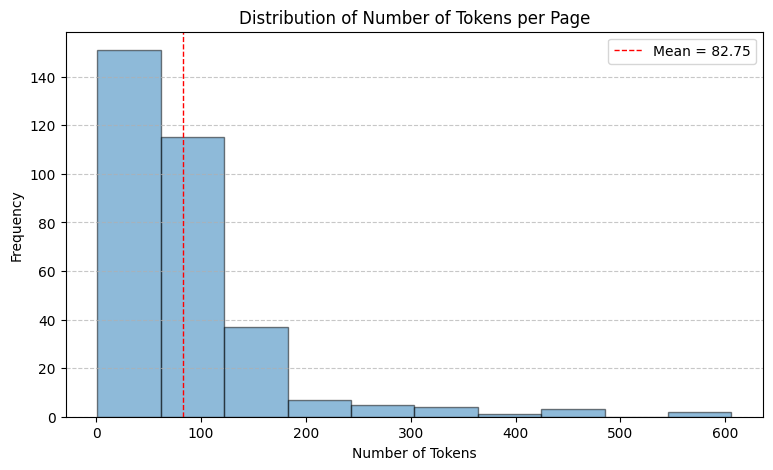

In [22]:
# plot the distribution of number of tokens per page showing the mean
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean
mean_tokens = np.mean(num_token_per_page)

# Create the plot
plt.figure(figsize=(9, 5))
plt.hist(num_token_per_page, bins=10, edgecolor='black', alpha=0.5)
plt.axvline(mean_tokens, color='red', linestyle='dashed', linewidth=1, label=f'Mean = {mean_tokens:.2f}')
plt.title('Distribution of Number of Tokens per Page')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


# Splitting Content into Tokenized Chunks
Here we divide the processed elements in `df_elements` into smaller text files, ensuring each file stays within a token limit.

**Chunk Creation:**
- Processes elements in `df_elements`:
  - Concatenates values until the token count exceeds `doc_tokens_threshold`.
  - Writes each chunk to a separate text file (`docX.txt`).
  - Tracks the token count of each chunk in `docs_len`.
- Handles `PageBreak` to reset and manage document boundaries.

Adjust `doc_tokens_threshold` to change the maximum token count per file.


In [23]:
import os

# create folder chunks if it doesn't exist
if not os.path.exists('chunks'):
    os.makedirs('chunks')
else:
    # delete all the files in the folder chunks
    for file in os.listdir('chunks'):
        os.remove(os.path.join('chunks', file))


block = ""
document = ""
doc_index = 0
doc_tokens_threshold = 150
docs_len = []

# iterating over df_elements
for i in range(len(df_elements)):


  if df_elements.at[i, 'Type'] != PageBreak:

    next_element = df_elements.at[i, 'Value'] + " "

    if count_tokens(block) + count_tokens(next_element) > doc_tokens_threshold:
        with open('chunks/document_' + str(doc_index) + '.txt', 'w') as f:
          f.write(block)

        docs_len.append(count_tokens(block))
        doc_index += 1
        block = ""

    block += next_element

  else: # if the type is a PageBreak

    expected_num_tokens = count_tokens(document) + count_tokens(block)
    if expected_num_tokens > doc_tokens_threshold:

      with open('chunks/document_' + str(doc_index) + '.txt', 'w') as f:
        f.write(document)

      docs_len.append(count_tokens(document))
      doc_index += 1
      document = ""

    document += block
    block = ""

print("Number of chunks obtained: " + str(doc_index))

Number of chunks obtained: 247


In [24]:
# print the max, the min and the avg of values in docs_len
print(len(docs_len))

print(max(docs_len))
print(min(docs_len))
print(sum(docs_len)/len(docs_len))

247
150
35
117.90283400809717


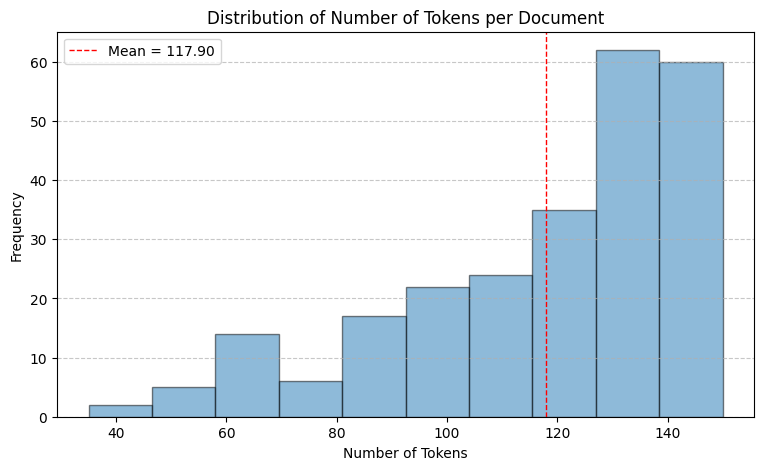

In [25]:
# plot the distribution of number of tokens per document showing the mean
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean
mean_tokens = np.mean(docs_len)

# Create the plot
plt.figure(figsize=(9, 5))
plt.hist(docs_len, bins=10, edgecolor='black', alpha=0.5)
plt.axvline(mean_tokens, color='red', linestyle='dashed', linewidth=1, label=f'Mean = {mean_tokens:.2f}')
plt.title('Distribution of Number of Tokens per Document')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# FROM HERE THE LM NOTEBOOK

# RAG Pipeline on PDFs with Limited GPU Requirements

In this project, we aim to build a **Retrieval-Augmented Generation (RAG)** pipeline optimized for **limited GPU environments**. The goal is to combine the power of *dense retrieval-based methods* with the flexibility of generative models, while ensuring the system remains efficient enough to run on medium-tier laptops with GPUs.

A RAG pipeline consists of two main stages: **retrieval** and **generation**. The entire process can be divided into **3 key steps**:

1. **Generation of document embeddings**  
   In this step, document embeddings are generated from a *corpus* using an embedding model. Each document is encoded into a dense vector representation, capturing semantic information.

2. **Document retrieval**  
   Relevant documents are fetched from the corpus based on the input query. This is achieved by utilizing the generated embeddings and calculating similarity with the query's embedding to retrieve the most relevant documents.

3. **Output generation**  
   The retrieved documents are then passed to a **generative model**, which produces contextually relevant responses based on the information extracted from the documents.

By leveraging lightweight models and optimizing for efficiency, this RAG pipeline delivers powerful **AI-driven results** even on hardware with **limited resources**.

Finally, a **Gradio interface** is provided, allowing users to interact with the system and "chat" with the documents they provide, offering a seamless experience for exploring the content.

## Hardware requirements and constraints

Let's find out what hardware we've got available to see what kind of model(s) we'll be able to load.

> **Note:** You can also check this with the `!nvidia-smi` command.

In [26]:
%pip install -q -U transformers

Note: you may need to restart the kernel to use updated packages.


In [27]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [28]:
# Get GPU available memory
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")
print(torch.cuda.get_device_name(0))

Available GPU memory: 8 GB
NVIDIA GeForce RTX 3070 Laptop GPU


Of course, depending on the provided harware, better models can be utilized.

### Checking local GPU memory availability

Let's first analyze how we decided the model to use for this project. This notebook was primarily run and tested locally on a **laptop** with 16GB of RAM and an NVIDIA RTX 3070 laptop GPU (8GB of VRAM). The main goal was to create a pipeline that could efficiently run on this portable device, leveraging the benefits of GPUs and CUDA for AI tasks while ensuring that the performance and capabilities did not feel lacking compared to larger models.

We will need two main ingredients:
- An *embedder* model, that calculates dense embeddings from documents
- An *LLM*, that provides output given user's queries and the retrieved documents

In their dedicated sections we will uncover the choiches made for both.

### Load our PDF and start producing chunks

Let's now start by loading a pdf file and extracting chunks from it. These chunks' **quality** is important, since these will be essentially the *documents* on which we will compute the embeddings on.

In [29]:
from huggingface_hub import login
from dotenv import load_dotenv

PDF_NAME = "Information Retrieval Slides.pdf"
running_on_colab = False

try:
    from google.colab import userdata # type: ignore
    HF_TOKEN = userdata.get('HF_TOKEN')
    print("Running in Google Colab. Using userdata to get HF_TOKEN.")
    running_on_colab = True
except ModuleNotFoundError:
    load_dotenv()
    HF_TOKEN = os.getenv('HF_TOKEN')
    print("Not running in Google Colab. Using load_dotenv to get HF_TOKEN.")

file_path = PDF_NAME
login(token=HF_TOKEN)

Not running in Google Colab. Using load_dotenv to get HF_TOKEN.


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [30]:
# HERE NEW CODE

corpus = []
# for each document in chunks folder append its text to corpus
for file in sorted(os.listdir("chunks")):
    with open(os.path.join("chunks", file), "r", encoding="utf-8") as f:
        corpus.append(f.read())

print(len(corpus))

247


Let's give a look to some random documents extracted and preprocessed from the initial pdf

In [31]:
import random

# print some random pages with their indices
random.seed(42)
for i in range(5):
    doc = random.choice(corpus)
    doc_index = corpus.index(doc)
    #print(f"DocId: {doc_index}, {doc.page_content[:100]}...")
    print(f"DocId: {doc_index}, {doc[:100]}...")

DocId: 163, Okapi BM25 The term frequency \(tf{i}^{r}\) can be represented as a normalised value with respect to...
DocId: 28, Odds and BIM O(r | x, q) = O(r | q) n  P(xi | r, q) P(xi | r, q) i=1   Since either xi = 0 or xi = 1...
DocId: 6, Probability Axioms (1) Given the sample space , the function S is is called probability. P : F     F...
DocId: 189, DAAT Pseudocode 5.7 Query Processing procedure DAATR(Q, I, f , g, k) L Array()  R PriorityQueue(k)  ...
DocId: 70, Machine Learning for IR Ranking You know many machine learning algorithms:   Naive bayes, support ve...


In [32]:
#print(f"Average document length: {sum(len(doc.page_content) for doc in corpus) / len(corpus)}")
print(f"Average document length: {sum(len(doc) for doc in corpus) / len(corpus)}")

Average document length: 560.3198380566802


We also provide a `save_documents` function, which can be useful for further inspection of the PDF content.

In [33]:
# import os

# def save_documents(documents):
#     """
#     Save the provided documents to the vector_store directory. Each document is saved as a separate text file.
#     """
#     if not os.path.exists("vector_store"):
#         os.makedirs("vector_store")
#     # delete all files in the vector_store directory
#     for file in os.listdir("vector_store"):
#         os.remove(os.path.join("vector_store", file))
#     for i, doc in enumerate(documents):
#         with open(f"vector_store/document_{i}.txt", "w", encoding="utf-8") as f:
#             f.write(doc.page_content)

In [34]:
#save_documents(corpus)
print(f"Saved {len(corpus)} documents in the vector_store directory.")

Saved 247 documents in the vector_store directory.


In [35]:
import json

def extract_questions(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    questions = []
    for item in data:
        # q = item.get("question", "")
        # a = item.get("answers", "")
        # # 'a' è una lista di stringhe, aggiungi ad ognuno 1, 2, 3, 4
        # for i in range(len(a)):
        #     a[i] = f"{(1 + i)}) {a[i]}"
        # a = " ".join(a)
        # qplusa = f"{q} {a}"
        if str(item.get("category", "")) == "1":
            continue
        question = {
            "question": item.get("question", "").strip(),
            # "answers": item.get("answers", ""),
            # "correct": item.get("correct", ""),
            # "category": item.get("category", ""),
            # "question_id": item.get("question_id", "")
        }
        questions.append(question)
    return questions


file_path = "quiz/quiz.json"

if running_on_colab:
  if not os.path.exists("quiz"):
      os.makedirs("quiz")
  # save locally from https://drive.google.com/file/d/15pKNg7XwtaUILmxUhzhNa-ojTpqqLg__/view?usp=drive_link
  gdown.download(id="15pKNg7XwtaUILmxUhzhNa-ojTpqqLg__", output=file_path, quiet=False)

queries = extract_questions(file_path)
print(f"Loaded {len(queries)} questions.")

random.seed(4242)
print(random.choice(queries))

Loaded 60 questions.
{'question': 'Which of the following metrics is used to measure overlap between two sets?'}


## Gather Dataset Embeddings

In this first stage, the aim is to produce the documents embeddings, in order to be able to make similarity searches in the upcoming steps of the pipeline.

### About the `cde-small-v1` Model

The `cde-small-v1` model, developed by John X. Morris and Alexander M. Rush, is a cutting-edge model for generating **Contextual Document Embeddings (CDE)** ([link](https://huggingface.co/jxm/cde-small-v1)). What sets this model apart is its ability to integrate "*context tokens*" into the embedding process, which allows it to capture the nuances and relationships between documents more effectively. This makes it particularly suitable for generating highly accurate embeddings for both documents and queries, especially in cases where capturing the context of a document within the broader corpus is crucial.

We chose this model because, as of December 2024, it is one of the leading models under 400M parameters, delivering impressive results on the [**Massive Text Embedding Benchmark (MTEB) leaderboard**](https://huggingface.co/spaces/mteb/leaderboard). Although it ranks 32nd overall, it stands out as the top model in terms of **memory efficiency**, which is a key factor for our project, given the requirement for **limited GPU capabilities**. Additionally, it offers a substantial **embedding dimension of 768**, striking a balance between computational efficiency and embedding quality.

<style>
    img {
        border-radius: 15px;
    }
</style>
![assets/cde-small-v1.png](https://github.com/giuliocapecchi/LM-project/blob/main/assets/cde-small-v1.png?raw=1)

A key feature of the `cde-small-v1` model is its optimization for a two-stage embedding process:

1. **First Stage**: Embedding a subset of documents from the corpus to create "dataset embeddings," which serve as a **reference** for the entire corpus.
2. **Second Stage**: Using the dataset embeddings to embed new queries and documents during inference.

This model is compact yet delivers solid performance, making it suitable for our use case.

### Steps to Gather Dataset Embeddings:

1. **Selecting a Subset of Documents**  
   We begin by sampling a representative set of documents from the corpus. Following the model's guidelines, we select 512 documents. If this number isn't available, the model can handle oversampling, which is the case for the PDF dataset we're using. Despite this, performance remains strong.

2. **Generating Dataset Embeddings**  
   After selecting the documents, we encode them using the `cde-small-v1` embedding model. This step produces dense vector representations of the documents, which are representative of the broader corpus.

3. **Embedding Queries and Documents**  
   Once the dataset embeddings are created, we use them to embed both documents and queries. A key feature of this model is its ability to differentiate between 'queries' and 'documents' during encoding, ensuring context is preserved during the embedding process.


Next, we will load the model using the `SentenceTransformers` interface to begin the embedding process.

In [36]:
from sentence_transformers import SentenceTransformer

# with sentence-transformers we don't need prefixes but, to do retrieval, we need to use prompt_name="query" and prompt_name="document" in the encode method of the model when embedding queries and documents, respectively.
embeddings_model = SentenceTransformer(
    "jxm/cde-small-v1",
    trust_remote_code=True,
).to(device)

C:\Users\giuli\.cache\huggingface\modules\transformers_modules\nomic-ai\nomic-bert-2048\40b98394640e630d5276807046089b233113aa87\modeling_hf_nomic_bert.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

Disabled 37 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v1.9e2ed1d8d569d34458913d2d246935c1b2324d11.model.BiEncoder'>
modified 12 rotary modules – set rotary_start_pos to 512
Disabled 74 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v1.9e2ed1d8d569d34458913d2d246935c1b2324d11.model.DatasetTransformer'>


During the development of the project, the creators of the embedding model made a change in the Hugging Face repository, which led to unstable results when using the `SentenceTransformer` implementation. If a similar issue arises in the future, it can be mitigated by specifying the `revision` and `tokenizer_kwargs` parameters in the model constructor. These parameters allow to lock the model and tokenizer to a specific branch name, tag, or commit ID from the Hugging Face repository, ensuring stability.

Here’s how to implement it:

```python
embeddings_model = SentenceTransformer(
    "jxm/cde-small-v1",
    trust_remote_code=True,
    revision="9e2ed1d8d569d34458913d2d246935c1b2324d11",  # Latest stable model revision
    tokenizer_kwargs={"revision": "86b5e0934494bd15c9632b12f734a8a67f723594"}  # Latest stable tokenizer revision
).to(device)
```

The tags provided above correspond to the latest stable commits (as of December 2024). You can retrieve them directly from the model's card page on Hugging Face, under the "Files and Versions" tab.

Fortunately for us, the issue was resolved the same day we reported it to the creators via Twitter. We thank them for their prompt response and the fix they provided.

Let's follow up by producing the `minicorpus` (which is the subsample of the whole corpus) and what we called `dataset_embeddings`

In [37]:
minicorpus_size = embeddings_model[0].config.transductive_corpus_size # 512
random.seed(4242)
minicorpus_docs = random.choices(corpus, k=minicorpus_size) # oversampling is okay
assert len(minicorpus_docs) == minicorpus_size # We must use exactly this many documents in the minicorpus

dataset_embeddings = embeddings_model.encode(
    #[doc.page_content for doc in minicorpus_docs],
    [doc for doc in minicorpus_docs],
    prompt_name="document",
    convert_to_tensor=True,
    show_progress_bar=True
)

print(f"Corpus size: {len(corpus)}")
print(f"Computed embeddings for {len(minicorpus_docs)} documents. Shape: {dataset_embeddings.shape}")

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Corpus size: 247
Computed embeddings for 512 documents. Shape: torch.Size([512, 768])


In [38]:
print("Some mini-corpus documents:")

# get some random documents from the minicorpus
random.seed(4242)
for i in random.sample(range(minicorpus_size), 5):
    #print(f"document {i}: {minicorpus_docs[i].page_content[:100]}...")
    print(f"document {i}: {minicorpus_docs[i][:100]}...")

Some mini-corpus documents:
document 425: The number of such arrangements is given by \(C(n,r)\), defined as: \[C(n,r)=\frac{P(n,r)}{r!}=\frac...
document 134: Means , say 60 km/h, v1 v2 Ferger, W. F. (1931). The Nature and Use of the Harmonic Mean. Journal of...
document 29: Learning To Rank Steps Sample identification Apply BM25 to rank documents with respect to a query   ...
document 399: Information Retrieval in 1620   Which plays of Shakespeare contain the words Brutus AND Caesar but N...
document 388: Auxiliary Data Structures   Lexicon (or vocabulary)   Contains the term statistics across the whole ...


Now that we have obtained the **dataset embeddings**, we can proceed to embed both documents and queries using the same model.

To embed the documents and queries, we must ensure that we specify the correct `prompt_name` for each, as well as pass the `dataset_embeddings` to maintain context. The reason is that, as many state-of-the-art-models, this one was trained with task-specific prefixes:

- For documents, use:  
  `prompt_name="document"`

- For queries, use:  
  `prompt_name="query"`

We also have to always additionally, specify  the `dataset_embeddings`, in order to use the once we produced before.

By doing so, we ensure that the embeddings are generated with the correct context for both retrieval and generation tasks, leveraging the efficient performance of the `cde-small-v1` model.

In [39]:
doc_embeddings = embeddings_model.encode(
    #[doc.page_content for doc in corpus],
    [doc for doc in corpus],
    prompt_name="document",
    dataset_embeddings=dataset_embeddings, # this is the contexualized embeddings of the minicorpus
    convert_to_tensor=True,
    show_progress_bar=True
)

query_embeddings = embeddings_model.encode(
    [query['question'] for query in queries],
    prompt_name="query",
    dataset_embeddings=dataset_embeddings,  # this is the contexualized embeddings of the minicorpus
    convert_to_tensor=True,
    show_progress_bar=True
)

print(f"Document embeddings shape: {doc_embeddings.shape}")
print(f"Query embeddings shape: {query_embeddings.shape}")

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Document embeddings shape: torch.Size([247, 768])
Query embeddings shape: torch.Size([60, 768])


We can now computes similarities between the embeddings and all the queries by simply calling `embeddings_model.similarity` (which uses by default cosine similarity), and inspect some of the results obtained.

In [40]:
similarities = embeddings_model.similarity(query_embeddings, doc_embeddings)
print("'similarities' shape : ",similarities.shape)
topk_values, topk_indices = similarities.topk(5)

random.seed(4242)
random_queries = random.sample(queries, 2)
for query in random_queries:
    query_idx = queries.index(query)
    print(f"Query: {query['question']}")
    for j, idx in enumerate(topk_indices[query_idx]):
        doc = corpus[idx]
        #print(f"Rank {j+1} (Score: {topk_values[query_idx][j]:.4f}, Doc ID: {idx}): {doc.page_content[:200]}...")
        print(f"Rank {j+1} (Score: {topk_values[query_idx][j]:.4f}, Doc ID: {idx}): {doc[:200]}...")
    print()

'similarities' shape :  torch.Size([60, 247])
Query: Which of the following metrics is used to measure overlap between two sets?
Rank 1 (Score: 0.6265, Doc ID: 118): Jaccard Coefficient A common measure of overlap of two (finite) sets \(A\) and \(B\): \[J(A,B)=\frac{|A\cap B\,|}{|A\cup B\,|}\] Always assigns a number between 0 and 1 \(A\) and \(B\) do not have to ...
Rank 2 (Score: 0.6061, Doc ID: 201): Jaccard Coefficient A common measure of overlap of two (finite) sets and : J(A, B) = | A  B | | A  B | Always assigns a number between 0 and 1 A and do not have to be the same size B   Note that J(A, ...
Rank 3 (Score: 0.5652, Doc ID: 110): A/B Testing   Concept is fairly trivial: randomly split traffic between two (or more) versions   A (Control) & B (Treatment) Collect metrics of interest & analyse Run statistical tests to confirm diff...
Rank 4 (Score: 0.5399, Doc ID: 131): Let \(A{i}\) with \(i=1,\ldots,n\) be such that, for all \(i\), \(A{i}\neq\emptyset\). We say that \(\{A{1},\ld

## Chroma

While not strictly necessary for this project - since the provided PDF is relatively small - we decided to integrate a vector database to enhance the storage and retrieval of the embeddings produced. This integration becomes particularly valuable when larger files are processed, as they often require splitting the corpus into smaller chunks, with each chunk generating its own embedding. The resulting large number of embeddings makes efficient storage and retrieval mechanisms increasingly important.

After evaluating various options, we selected [**Chroma**](https://www.trychroma.com/) for its simplicity of local deployment and good performances. Chroma is particularly well-suited for managing **large document collections**, providing **faster retrieval** and ensuring that the pipeline remains robust and adaptable to big files.

### Implementation Steps

We begin by creating a Chroma client and verifying if a collection named `'chroma-collection'` already exists locally:  if it does, we delete it to ensure a clean state before initializing a new one.

For reference, a Chroma client can be instantiated in two ways :

- in an **ephemeral way** (in-memory), particularly useful for experimentation, such as testing different embedding functions and retrieval techniques. If data persistence is not a requirement, this approach provides a lightweight and efficient way to get started with Chroma while maintaining flexibility for quick iterations. This can be achieved with the following code:

    ```python
    import chromadb
    client = chromadb.Client()
    ```

- with a **persistent client**. This can be done by providing a  path where Chroma will store its database files on disk, and load them on start.

    ```python
    import chromadb
    client = chromadb.PersistentClient(path="/path/to/save/to")
    ```
    If a `path` is not provided, the default is `.chroma`

More about Chroma can be found in its [documentation](https://docs.trychroma.com/docs/overview/introduction). We choose to utilize the **persistent** approach, so let's follow by instantiating a `PersistentClient`;  if the collection already exists, we delete it to ensure a clean state before initializing a new one.


In [41]:
from chromadb import PersistentClient, Collection

COLLECTION_NAME = "chroma-collection"

# Initialize the Chroma client
client = PersistentClient(path="./"+COLLECTION_NAME)

# Check if the collection exists and delete it if it does
if COLLECTION_NAME in [col.name for col in client.list_collections()]:
    client.delete_collection(name=COLLECTION_NAME)
    print(f"Collection {COLLECTION_NAME} exists, deleting it")
else:
    print(f"Collection {COLLECTION_NAME} does not exist")

Collection chroma-collection exists, deleting it


### Integration of `cde-small-v1` with Chroma

Integrating the **`cde-small-v1`** embedding model with Chroma required the creation of a custom `EmbeddingFunction`. This was necessary because **`cde-small-v1`** has a distinct workflow that deviates from standard embedding models. Specifically, as said it uses:

- **`prompt_name`**: This parameter distinguishes between "document" and "query" embeddings, to have proper alignment during retrieval tasks.
- **`dataset_embeddings`**: These provide a reference for conditional embedding generation, improving contextual accuracy in embeddings.

By default, Chroma does not natively support these additional parameters. However, it offers the flexibility of extending the `EmbeddingFunction` protocol, allowing us to integrate the specific requirements of the **`cde-small-v1`** model into Chroma’s workflow.

We can check the type of the elements of the corpus produced by our chunking functions and use it to differentiate between queries and documents.

In [42]:
print(type(corpus[0]))

<class 'str'>


In [43]:
from chromadb import Documents, EmbeddingFunction, Embeddings


class CustomEmbeddingFunction(EmbeddingFunction):
    def __call__(self, input: Documents) -> Embeddings:
        """
        Automatically detect if the input is a document or a query and set the mode accordingly.
        :param input: Documents or queries to embed.
        :return: Embeddings.
        """
        # Detect the mode: "document" if the input is a list of documents, else "query".
        mode = "query" #"document" if isinstance(input[0], langchain_core.documents.base.Document) else "query"

        # If the input is a list of Documents, extract the text.
        #if isinstance(input, list):
        #    input = [doc if isinstance(doc, str) else doc.page_content for doc in input]

        # Generate embeddings using the model with the determined mode
        embeddings = embeddings_model.encode(
            input,
            prompt_name=mode,
            dataset_embeddings=dataset_embeddings,
            convert_to_tensor=True,
        ).cpu().numpy()

        return embeddings.tolist()

# Create an instance of the embeddings function for queries (we already calculated all the embeddings of the documents)
custom_embedding_function = CustomEmbeddingFunction()

Furthermore, while Chroma defaults to using Euclidean distance (`l2`) for nearest-neighbor search, the **`cde-small-v1`** embeddings from `SentenceTransformers` are based on cosine similarity by default. To utilize it, We configure the metadata parameter `"hnsw:space": "cosine"` when creating the collection. This ensures that Chroma uses cosine similarity, aligning with the previous behavior.

<style>
    img {
        border-radius: 15px;
    }
</style>
![chroma-similarity-measures.png](https://github.com/giuliocapecchi/LM-project/blob/main/assets/chroma-similarity-measures.png?raw=1)

Once the collection is configured, we add all the documents and their precomputed embeddings to it.

> **NOTE:** We manually computed the embeddings beforehand (for analysis purposes) in the previous steps. If we had only provided the documents, Chroma would have automatically generated the embeddings using the `CustomEmbeddingFunction`, without the need for precomputation.

In [44]:
# Create a Chroma collection with the custom embedding function
collection: Collection = client.create_collection(
    name=COLLECTION_NAME,
    embedding_function=custom_embedding_function,
    get_or_create=True,
    metadata={"hnsw:space": "cosine"} # l2 is the default but cosine is more suitable for this embedding function
)

# Add the documents and their (already computed) embeddings to the collection
collection.add(
    ids=[str(i) for i in range(len(corpus))],  # Unique identifiers for the documents
    embeddings=doc_embeddings.cpu().numpy(),
    #documents=[doc.page_content for doc in corpus],
    documents=[doc for doc in corpus],
)

In [45]:
#print(collection.peek()) # returns a list of the first 10 items in the collection
print("Number of documents in the corpus: ",len(corpus))
print("Number of documents in the collection: ",collection.count()) # returns the number of items in the collection

Number of documents in the corpus:  247
Number of documents in the collection:  247


We can finally test `collection.query` to make some calls to the Chroma collection, and we expect similar (ideally, the same) results as above, when we used `model.similarity`.

In [46]:
query_text = "How many bytes can UTF-8 use to encode a character?"

# create a Document object with the query text
results = collection.query(
    query_texts=query_text,
    n_results=5
)
print(results)

# Print the results with the document IDs and scores
for i, (doc_id, score, doc) in enumerate(zip(results['ids'][0], results['distances'][0], results['documents'][0])):
    print(f"Rank {i+1}: Document ID: {doc_id}, Score: {1-score:.4f}, {doc[:200]}")

{'ids': [['112', '170', '0', '181', '192']], 'embeddings': None, 'documents': [["UTF-8   All Unicode characters larger than U+007F are encoded as a sequence of two or more bytes, each of which has the most significant bit set   This means that no ASCII byte can appear as part of any other character, because ASCII characters are the only characters whose leading bit is 0   The first byte of a multibyte sequence that represents a non-ASCII character is always in the range 0xC0 to 0xFD and it indicates how many bytes follow for this character   One of 110xxxxx, 1110xxxx, 11110xxx, 111110xx, and 1111110x, where the x's may be 0's or 1's.   The number of 1-bits following the first 1-bit up until the next 0-bit is the number of bytes in the rest of the sequence. ", 'UTF-8 Unicode is not a character encoding scheme Unicode code points are just numeric values assigned to characters   Code points are not representations of characters as sequences of bytes   For example, the code point U+0C36 is

... which is exactly identical to the previous ones.

One final thing to note is that in Chroma cosine similarity is calculated as `1 - cosim` ; this is done to ensure that lower values indicate a better position in the ranked list. To obtain results consistent with the previous ones, we subtractde the score from one in the above code.


### Compute scores between queries and documents

Now we can analyze a similarity heatmap between the embeddings of our documents and the provided queries. The results show consistency with the following observations:

- **Few documents match the queries**: This suggests that the matching documents are likely the most relevant ones.
- **Matches often occur in subsequent documents**: This is expected since the corpus was split into chunks based on the document's structure. For example, chapters are separated, so answers to specific questions are more likely to be located within the same chapter or adjacent sections of the document.

Additionally, we provide a distribution of the similarity scores. This helps us assess whether an empirical threshold can be established to determine which documents are truly similar to the provided queries.

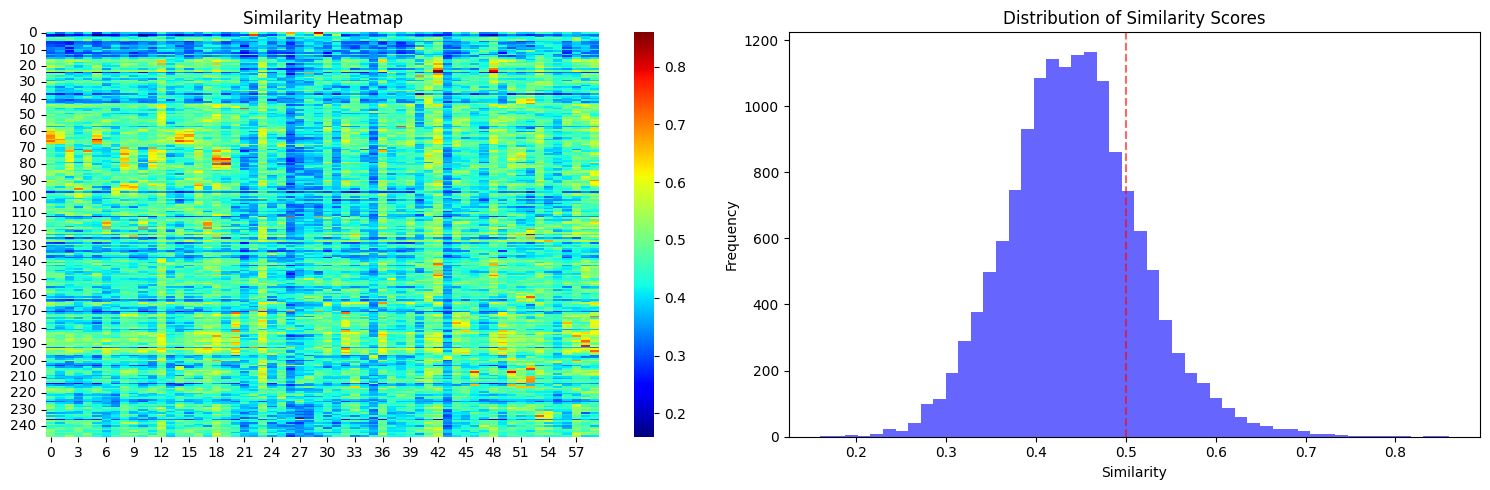

In [47]:
from seaborn import heatmap
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot heatmap
heatmap(similarities.cpu().numpy().T, cmap="jet", ax=axes[0])
axes[0].set_title("Similarity Heatmap")

# Plot histogram
axes[1].hist(similarities.cpu().flatten(), bins=50, color='blue', alpha=0.6)
axes[1].set_title("Distribution of Similarity Scores")
axes[1].set_xlabel("Similarity")
axes[1].set_ylabel("Frequency")
axes[1].axvline(x=0.5, color='red', alpha=0.6, linestyle='--')

plt.tight_layout()
plt.show()

## LLM

After conducting some research, we chose to work with one of Meta's latest smaller open-source Llama models available at the time of writing this notebook: [Llama-3.2-3B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct), released the *25th of September 2024*. We specifically selected the *instruct* variant because it is pre-trained to follow basic instructions, offering a more user-friendly and fine-tuned experience compared to the standard non-instruct version (which is also available). Below, we review this model's [specifications](https://llamaimodel.com/requirements-3-2/):

| **Llama 3.2 3B Instruct Model Specifications**                    | **Requirement**       | **Details**                                                                                  |
|----------------------------------|-----------------------|----------------------------------------------------------------------------------------------|
| Parameters                       | 3 billion             |                                                                                              |
| Context Length                   | 128,000 tokens        |                                                                                              |
| **Hardware Requirements**        |                       |                                                                                              |
| CPU and RAM                      |                       | CPU: Multicore processor <br> RAM: Minimum of 16 GB recommended                              |
| GPU                              |                       | NVIDIA RTX series (for optimal performance), at least 8 GB VRAM                              |
| **Estimated GPU Memory Requirements** |                       |                                                                                              |
| Higher Precision Modes           | BF16/FP16             | ~6.5 GB                                                                                      |
| Lower Precision Modes            | FP8                   | ~3.2 GB                                                                                      |
|                                  | INT4                  | ~1.75 GB                                                                                     |
| **Software Requirements**        |                       |                                                                                              |
| Software Dependencies            |                       | Frameworks: PyTorch <br> Libraries: Hugging Face Transformers (version 4.45.0 or higher), CUDA |

In [48]:
print("Is bf16 supported: ",torch.cuda.is_bf16_supported())

Is bf16 supported:  True


The `bitsandbytes` library is a lightweight Python wrapper around CUDA custom functions, in particular 8-bit optimizers, matrix multiplication (LLM.int8()), and 8 & 4-bit quantization functions.

The library includes quantization primitives for 8-bit & 4-bit operations, through `bitsandbytes.nn.Linear8bitLt` and `bitsandbytes.nn.Linear4bit` and 8-bit optimizers through bitsandbytes.optim module.

#### Quantization Choices

We chose a *middle ground* by loading the model with **4-bit quantization** while maintaining **BFloat16** precision for computation.

The use of 4-bit quantization reduces the precision of the model’s weights to just 4 bits per value, significantly lowering memory usage and accelerating inference. This method retains only the most essential information, sacrificing some numerical precision, but allows for larger models to be handled on GPUs with limited memory. Despite the weights being quantized to 4 bits, the model still performs computations in **16-bit floating point (BFloat16)** precision. BFloat16 is a 16-bit format that preserves much of the dynamic range of floating-point operations while requiring less memory than the traditional 32-bit format. This way, while the 4-bit quantization reduces the memory footprint of the model weights, the computation is performed in BFloat16, optimizing performance on modern GPUs that are tailored for BFloat16 operations. This configuration strikes a balance between computational efficiency and numerical precision, enabling fast inferences with minimal memory usage without significant loss in result quality.

Given the hardware constraints, we opted for **4-bit quantization** using `BitsAndBytes` (as explained later). This approach greatly reduces the memory footprint and speeds up inference, ensuring acceptable performance for our use case. Without this configuration, the GPU’s memory usage was consistently at 100%, and inference times were approximately 2-3 minutes per query. With 4-bit quantization, memory usage drops to about 6GB, preventing GPU overload and reducing inference time to around 30 seconds per query, delivering satisfactory results. Further details on the quantization process will be provided later.

However, we also need to consider that both the embedding model and the LLM must be loaded into memory, which adds another layer of complexity to the memory management. This requires careful balancing, as the total memory usage must accommodate both the LLM and the embedding model simultaneously. We will address how we manage this in the next section.

In [49]:
from transformers import (
    BitsAndBytesConfig,
    AutoModelForCausalLM,
    AutoTokenizer
)

MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"

# Quantization is a technique that reduces the precision of
# the model’s weights to make it run faster and consume less memory,
# often at the cost of a slight reduction in model accuracy or quality
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                      # Lower precision reduces memory usage and can speed up inference (maybe try 8)
    bnb_4bit_use_double_quant=True,         # Using double quantization can help reduce the loss in accuracy associated with quantization
    bnb_4bit_quant_type="nf4",              # Normal Float 4-bit quantization, a scheme that may preserve model quality better than straightforward quantization methods
    bnb_4bit_compute_dtype=torch.bfloat16,  # The internal compute dtype used during inference. bfloat16 (BF16) is often chosen because it’s efficient on modern accelerators
    llm_int8_enable_fp32_cpu_offload=True   # Enable FP32 CPU offload
)


llm_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map={"": device},  # Custom device map to ensure all modules are on GPU
    quantization_config=bnb_config,
).to(device)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

generation_config = llm_model.generation_config
generation_config.max_new_tokens = 200                    # the maximum number of new tokens the model will generate (long outputs might be more prone to off-topic or repetitive content)
generation_config.min_new_tokens = 1                      # the minimum number of new tokens the model will generate
generation_config.temperature = 0.1                       # it controls the randomness of the generation, lower temp means more deterministic, conservative (less creative) and repetitive answers [about 0.1-1.2]
generation_config.top_p = 0.5                             # nucleus sampling controls how the model picks words based on their cumulative probability, lower value (0.5) means safer, more coherent text but less diverse [about 0.5-0.9]
generation_config.num_return_sequences = 1                # how many separate output sequences are returned for each generation prompt, get multiple different answers in one go, useful for picking the best response from several tries
generation_config.pad_token_id = tokenizer.eos_token_id   # special token IDs that represent padding and the end-of-sequence token. Generally, these are set to ensure the model knows when to stop and how to handle inputs of different lengths
generation_config.eos_token_id = tokenizer.eos_token_id
generation_config.repetition_penalty = 2.0                # discourages the model from repeating the same phrases or tokens over and over [about 1.0-2.0] (high value cause the model to avoid some tokens even if they are contextually appropriate)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [50]:
# Check GPU usage
gpu_memory_gb = torch.cuda.get_device_properties(device).total_memory / (1024 ** 3)  # in GB
memory_allocated_gb = torch.cuda.memory_allocated(device) / (1024 ** 3)  # in GB
print(f"Memory Allocated: {memory_allocated_gb:.2f} GB")
print(f"Total memory usage: {(memory_allocated_gb / gpu_memory_gb) * 100:.2f}%")

Memory Allocated: 3.18 GB
Total memory usage: 39.74%


In [51]:
def retrieve_relevant_documents(query, k=5):
    results = collection.query( # query the Chroma collection
        query_texts=query,
        n_results=k
    )
    return results['documents'][0], results['distances'][0]

# test the function
query = "How many bytes can UTF-8 use to encode a character?"
print(f"Query: {query}")
documents, distances = retrieve_relevant_documents(query)
for doc, distance in (zip(documents, distances)):
    print(f"(score: {1-distance:.4f}) {doc[:200]}")

Query: How many bytes can UTF-8 use to encode a character?
(score: 0.7481) UTF-8   All Unicode characters larger than U+007F are encoded as a sequence of two or more bytes, each of which has the most significant bit set   This means that no ASCII byte can appear as part of a
(score: 0.7328) UTF-8 Unicode is not a character encoding scheme Unicode code points are just numeric values assigned to characters   Code points are not representations of characters as sequences of bytes   For exam
(score: 0.6772) Multimedia Information Retrieval and Computer Vision nicola.tonellotto@unipi.it Text Processing Encodings ASCII Character Encoding Scheme The ASCII encoding maps characters to 7-bit integers   using t
(score: 0.6355)   All further bytes in a multibyte sequence start with the two bits 10 and are in the range 0x80 to 0xBF   UTF-8 sequences must be of the following forms in binary, where the x's represent the bits fr
(score: 0.6334) UTF-8   The table below shows the ranges of Unicode code 

In [52]:
base_prompt =  '''You are an AI assistant for RAG.
Your task is to provide detailed and accurate answers to user questions based on the provided contexts.
If and only if ALL of the provided context lacks sufficient information, just state: "The provided context does not have the answer." without speculating or providing unsupported answers.
Keep the answers concise and professional and do not add informations that are not asked.

User question: {user_query}

Contexts:
{chunks_information}

Answer:
'''

In [53]:
import time

# Example usage of the RAG system with the PDF
def answer_questions(questions):
    count = 0
    error = 0
    results = {}

    current_time = time.strftime("%m%d-%H%M%S")

    pbar = tqdm(questions, total=len(questions), desc="Answering questions...", unit="question")
    for q in pbar:
        top_k_chunks = retrieve_relevant_documents(q['question'], k=5)
        retrieved_chunks = [chunk for chunk in top_k_chunks]
        prompt = base_prompt.format(user_query=q['question'], chunks_information="\n".join(retrieved_chunks))
        encoding = tokenizer(prompt, return_tensors="pt").to(device)
        with torch.inference_mode():
            outputs = llm_model.generate(
                input_ids=encoding.input_ids,
                attention_mask=encoding.attention_mask,
                generation_config=generation_config,
                num_beams=5,  # Use beam search for better results
                early_stopping=True,  # Stop early if all beams finish
            )

        # Exclude the prompt tokens from the generated output
        generated_tokens = outputs[0][len(encoding.input_ids[0]):]
        generated_unpreprocessed_sequence = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
        match = re.search(r'\b[1-4]\b', generated_unpreprocessed_sequence)
        answer = match.group(0) if match else ""  # first number found or empty string

        with open(f"quiz/runs_basemodel/quiz_answers_{current_time}.txt", "a", encoding="utf-8") as f:
            f.write(f"Question: {q['question']}\nAnswer: {answer}\nCorrect answer:{q['correct']}\nGenerated unpreprocessed sequence: {generated_unpreprocessed_sequence}\n--------------------------------------------------------------------\n\n")

        results[q['question_id']] = answer

        if len(answer) != 1 or answer not in "1234":
            error += 1
        else:  # the format is correct, now check if the answer is correct
            if str(q['correct']) == answer:
                count += 1
        pbar.set_postfix(Corrects=f"{count}/{len(questions)}", Errors=error)

    print("-------------------------\tFINISHED RUN. Error count: ", error, "-------------------------")
    return results, count / len(questions) * 100

# Gradio Interface <div align="center"><img src="https://www.gradio.app/_app/immutable/assets/gradio.CHB5adID.svg" alt="Gradio Logo" width="200"></div>

Lastly, we provide a **Gradio** interface to make interacting with the RAG pipeline both user-friendly and accessible. [Gradio](https://gradio.app) is a Python library that enables developers to quickly create customizable, interactive web-based interfaces. It is widely appreciated for its simplicity and flexibility.

The interface is launched in the next cell through the final command `demo.launch(debug=True)`

> This will also start a local server and generate a link (usually `http://127.0.0.1:7860`) that you can open in your browser.

The interface is straightforward:
- You can type your questions or prompts for the RAG pipeline into the **input field**.
- The interface estimated inference waiting time (based on the last response waiting time), then the generated answer.

If the interface is launched with the `debug=True` option (as in this case), it will also print the retrieved documents and their scores in the console; this can be useful for gaining insights into the system's behavior.

For mathematical formulas, `latex2mathml` is used: it is a Python library that convertes LateX formulas to MathML (an XML format for equations).

In [56]:
import gradio as gr

def query_rag_model(user_query):
    # Recupero dei documenti
    documents, scores = retrieve_relevant_documents(user_query, k=5)

    # Filtra i documenti con score >= 0.6
    filtered_documents = [doc for doc, score in zip(documents, scores) if 1 - score >= 0.5]
    filtered_scores = [score for score in scores if 1 - score >= 0.5]

    # Se nessun documento supera il threshold, passa alla prossima query
    if not filtered_documents:
        print(f"No relevant documents found for query: {user_query}")
        return "No relevant documents found."

    print("Filtered documents and their scores: ")
    for doc, score in zip(filtered_documents, filtered_scores):
        print(f"Score: {1-score:.4f}, {doc}")
    # Prompt per il modello
    prompt = base_prompt.format(user_query=user_query, chunks_information="\n".join(documents))
    encoding = tokenizer(prompt, return_tensors="pt").to(device)

    print("\n\nPROMPT: ",prompt)

    with torch.inference_mode():
        outputs = llm_model.generate(
            input_ids=encoding.input_ids,
            attention_mask=encoding.attention_mask,
            generation_config=generation_config,
            num_beams=5,
            early_stopping=True,
        )

    generated_tokens = outputs[0][len(encoding.input_ids[0]):]
    generated_sequence = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()

    print("Generated Text:", generated_sequence,"\n")

    return generated_sequence


latex_delimiters = [
    {"left": "\\[", "right": "\\]", "display": True},  # Formule in modalità display
    {"left": "\\(", "right": "\\)", "display": False},  # Formule inline
]

# Creazione dell'interfaccia Gradio con stile consistente
with gr.Blocks(css="""
    .input-box { border: 1px solid #ccc; border-radius: 4px; padding: 10px; margin: 10px 0; }
    .output-box { border: 1px solid #ccc; border-radius: 4px; padding: 10px; margin: 10px 0; background-color: #373535; height: auto; }

""") as demo:
    gr.Markdown("# RAG Model Query Interface")
    gr.Markdown("Ask questions to the RAG model and get answers based on the provided PDF context.")

    with gr.Row():
        with gr.Column():
            input_text = gr.Textbox(
                label="Enter your query",
                placeholder="Type your question here...",
                elem_classes=["input-box"]
            )

    with gr.Row():
        with gr.Column():
            output_text = gr.Markdown(
                label="Answer",
                elem_classes=["output-box"],
                latex_delimiters=latex_delimiters
                )
            

    input_text.submit(
        fn=query_rag_model,
        inputs=input_text,
        outputs=output_text
    )

# launch the interface
demo.launch(debug=True, show_error=True)

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Filtered documents and their scores: 
Score: 0.7549, Types of Learning To Rank Tasks List-wise approaches Consider the entire ranking of documents   Encapsulates a standard IR evaluation measure within the loss function   Not all measures are appropriate for list wise learning, e.g., P@3 vs NDCG@1000   Examples: AFS, LambdaMART Generally more effective than Point-wise or Pair-wise 
Score: 0.7210, Learning to Rank   Classification probably isn't the right way to think about approaching IR ranking: Classification problems: map to an unordered set of classes Regression problems: map to a real value   Ranking (or "ordinal regression") problems: map to an ordered set of classes   Learning to rank is the application of tailored machine learning techniques to automatically (select and) weight retrieval features Based on training data with relevance assessments   Learning to rank has been popularised by commercial search engines (e.g., Bing, Baidu, Yandex)   They require large training dataset